In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
os.chdir('C:/Users/chris/Documents/MnTe_data')

data1 = np.load('normData_MnTe_370K-330K_Total_fft.npy')
x1 = np.linspace(-24.9622, 24.9622, 661)* 4.1529
y1 = np.linspace(-24.9622, 24.9622, 661)* 4.1529
z1 = np.linspace(-16.6667, 16.6126, 616)* 6.7273

In [4]:
"""class to slice through three-dimensional data"""

import numpy as np
from scipy.interpolate import interpn

class Visualize:
    """create object containing three-dimensional data
    
    Args:
        m (numpy array): signal array (3D)
        x (numpy array): x-dimension coordinates (1D)
        y (numpy array): y-dimension coordinates (1D)
        z (numpy array): z-dimension coordinates (1D)
    """
    def __init__(self, m=None, x=None, y=None, z=None):
            
        self.m = m
        self.x = x
        self.y = y
        self.z = z
        self.a = None # these two instance attributes will construct an arbitrary grid
        self.b = None
        if m is None:
            self.m = np.array([])
        if x is None:
            self.x = np.array([])
        if y is None:
            self.y = np.array([])
        if z is None:
            self.z = np.array([])
        
    def three_points(self, p1, p2, p3):
        """find normal vector to the plane created by the three given points
        """
        
        # find two vectors from the three points which lie on the desired plane
        vec1 = p2 - p1
        vec2 = p3 - p1
        # now cross these two vectors to find a vector normal to the plane
        normal = np.cross(vec1, vec2)
    
        # now calculate the centroid of the three points given
        x_pos = (p1[0] + p2[0] + p3[0]) / 3
        y_pos = (p1[1] + p2[1] + p3[1]) / 3
        z_pos = (p1[2] + p2[2] + p3[2]) / 3
        cen_pt = np.array([x_pos, y_pos, z_pos])
        print('Center Point:', cen_pt)
        
        return normal, cen_pt
    
    def make_slice(self, len_a=None, len_b=None, dr=None, use_norm=None, 
                   cen_pt=None, normal=None, p1=None, p2=None, p3=None):
        """generate a slice through the dataset
        
        Args:
            side_len (float): the side length of the square slice to be taken through the data
            dr (float): determines the spacing of the grid (if dr=0.5, then there are 2 measurements every unit)
            use_norm (boolean): when True, will create slice from a normal vector and center point. When
                False, will create slice from three points
            cen_pt (numpy array): the center of the desired slice. Used when use_norm is True
            normal (numpy array): the normal vector to desired plane. Used when use_norm is True
            p1, p2, p3 (numpy array): three points in 3D space. The desired plane goes through these points.
                Used when use_norm is False
            
        Returns:
            2D array, along with space arrays, representing slice through 3D dataset
        """
        if dr is None:
            dr = 1
        if use_norm is None:
            use_norm = True
        if len_a is None:
            len_a = 10
        if len_b is None:
            len_b = 10
        if cen_pt is None:
            cen_pt = np.array([0, 0, 0])
        if normal is None:
            normal = np.array([1, 0, 0])
        if p1 is None:
            p1 = np.array([0, 1, 0])
        if p2 is None:
            p2 = np.array([1, 0, 0])
        if p3 is None:
            p3 = np.array([0, 0, 1])
        
        # First check if use_norm is False. If so, access three_points function 
            # to calculate the normal and cen_pt of the desired plane
        if use_norm is False:
            normal, cen_pt = self.three_points(p1, p2, p3)
         
        # ensure that our basis vector v1 is not the same as normal
        v1 = np.array([1, 0, 0])
        if np.allclose(v1, normal):
            v1 = np.array([0, 1, 0])
    
        # now make a matrix which will reflect any vector onto the orthogonal
            # complement of the normal vec, which is our desired plane
        # This is done by subtracting from the vector its component along the normal vector
        m_norm = np.eye(3) - (np.outer(normal, normal.T) / normal.T.dot(normal))
        
        # now reflect v1 using m_norm
        v1 = m_norm.dot(v1)
        # and create a new vector v2 that is orthogonal to both v1 and normal
        v2 = np.cross(normal, v1)
        # we now have 2 vectors to form our plane
    
        # now create and normalize Q, which will rotate an arbitrary 
            # slice to the orientation we desire
        Q = np.column_stack((v1, v2, np.zeros_like(v1)))
        Q[:,:2] /= np.linalg.norm(Q[:,:2], axis = 0)
    
        # now create an arbitrary slice
        self.a = np.arange(-len_a / 2, len_a / 2, dr)
        self.b = np.arange(-len_b / 2, len_b / 2, dr)
        self.a = np.append(self.a, len_a / 2)
        self.b = np.append(self.b, len_b / 2)
        A,B = np.meshgrid(self.a, self.b)
        locations = np.array([A.reshape(-1), B.reshape(-1), np.zeros(A.size)])  # the slice starts on the x-y plane
        # now move locations onto our two vectors, and add cen_pt to move slice into position
        locations = Q.dot(locations).T + (cen_pt)
    
        # now we need to interpolate our 3Dmpdf function over this slice
        points = (self.x, self.y, self.z)
        interp = interpn(points, self.m, locations)  # list of values of 3Dmpdf at locations
        slice1 = interp.reshape(len(self.b),len(self.a))
        
        return slice1, self.a, self.b

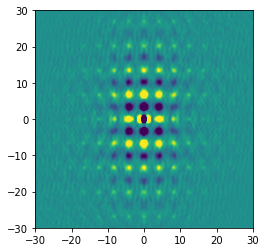

In [5]:
obj=Visualize(data1,x1,y1,z1)
plane,x,y = obj.make_slice(60,60,0.1,True,np.array([0,0,0]),np.array([0,1,0]))
plt.imshow(plane,vmin=-.15,vmax=0.15,extent=[min(x),max(x),min(y),max(y)])